![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

En promedio hay mayor número de alquileres de bicicletas en la temporada 3 (verano) y menor número de alquileres en la temporada 1 (invierno)

In [6]:
bikes.groupby('season').total.describe(percentiles=np.arange(0.1,1.0,0.1))

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
season,,,,,,,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,4.0,16.0,35.0,57.0,78.0,103.0,139.0,192.0,274.0,801.0
2,2733.0,215.251372,192.007843,1.0,11.0,31.0,74.0,125.0,172.0,225.2,283.0,363.0,504.8,873.0
3,2733.0,234.417124,197.151001,1.0,12.0,40.0,99.6,151.0,195.0,253.2,310.4,384.2,500.0,977.0
4,2734.0,198.988296,177.622409,1.0,10.0,31.0,74.0,119.0,161.0,205.0,256.0,334.0,447.7,948.0


* Para cada una de las categorías de la variable season, se tiene más o menos igual cantidad de registros. Para la categoría 1 se tiene menor cantidad de registros que las demás categorías.
* Al observar el valor del percentil 90 para temporada y el valor máximo, se puede observar que se tienen valores bastante extremos, que muy probablemente podrían deberse a fechas u horarios particulares.

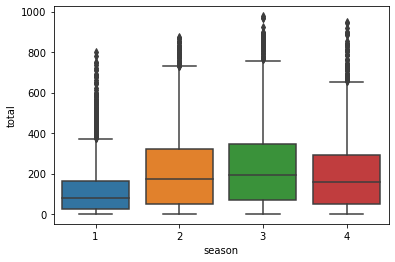

In [7]:
sns.boxplot(data=bikes,x="season", y="total")
plt.show()

* Se puede observar que para la temporada 1 (invierno) se tiene menor disperción en los datos, aunque parece haber mayor cantidad de datos atípicos.
* En promedio, para las temporadas 2 (primavera) y 3 (verano), la distribución del número de alquiler de bicicletas tiende a ser muy similar

In [8]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

En promedio las horas donde se presentan mayores alquileres de biciletas son entre las 16 y las 19 horas.

In [9]:
bikes.groupby('hour').total.describe(percentiles=np.arange(0.1,1.0,0.1))

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
hour,,,,,,,,,,,,,,
0,455.0,55.138462,43.620012,2.0,14.4,21.8,28.0,34.0,41.0,50.0,64.0,87.2,116.6,283.0
1,454.0,33.859031,34.112105,1.0,5.0,10.0,12.0,15.0,19.0,24.0,34.0,62.0,92.7,168.0
2,448.0,22.899554,26.110267,1.0,3.0,4.0,6.0,8.0,11.0,14.2,20.0,45.6,69.0,119.0
3,433.0,11.757506,12.666442,1.0,2.0,3.0,4.0,5.0,6.0,8.0,11.0,21.0,31.0,66.0
4,442.0,6.407240,4.217633,1.0,1.1,3.0,4.0,5.0,6.0,7.0,8.0,10.0,12.0,28.0
5,452.0,19.767699,12.784293,1.0,4.0,7.0,10.0,14.0,19.0,23.0,26.7,31.8,38.0,57.0
6,455.0,76.259341,54.745333,1.0,10.4,20.8,30.0,46.0,75.0,95.4,112.0,126.0,152.0,213.0
7,455.0,213.116484,159.207044,1.0,27.0,47.8,72.2,113.6,208.0,267.4,309.0,358.8,458.2,596.0
8,455.0,362.769231,231.723065,8.0,70.0,118.8,168.4,242.2,392.0,440.4,491.4,618.4,681.6,839.0


* Se observa similar cantidad de registros para todas las horas en la base de datos
* La hora con menor variación en la cantidad de alquileres es las 4 am y la de mayor variación es las 8 am
* En todas las horas se observa un rango bastante amplio entre el mínimo y máximo, especialmente en aquellas donde en promedio hay mayor cantidad de alquileres. Es probable que se deba a que la base de datos contiene también días especiales donde generalmente hay pocos alquileres.

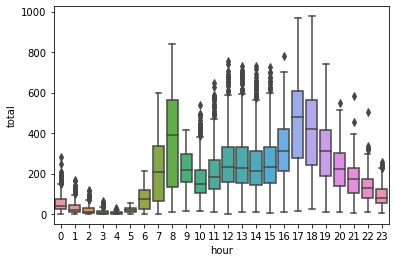

In [10]:
sns.boxplot(data=bikes,x="hour", y="total")
plt.show()

En la anterior gráfica se puede observar la distribución del total de alquileres por hora, se puede ver que efectivamente luego de las 7 hasta las 22 se observa la mayor cantidad de alquileres, con mayores picos en las 8 y 17.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

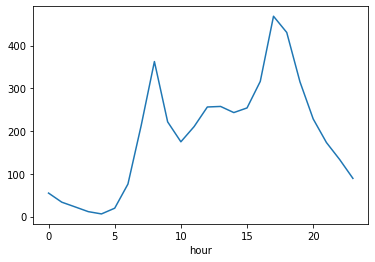

In [11]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

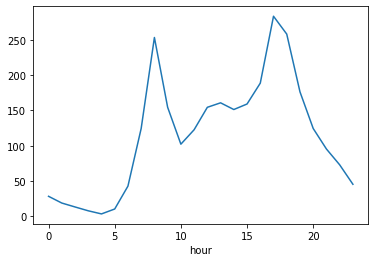

In [12]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes["season"] == 1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

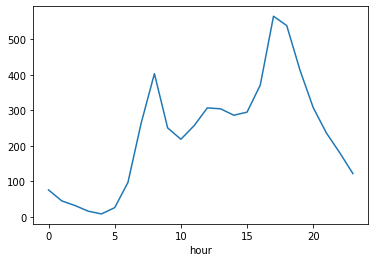

In [13]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes["season"] == 3].groupby('hour').total.mean().plot()

Al comparar las gráficas anteriores, se puede observar que la distribución del total de alquileres por hora sin importar la temporada es muy similar, observándose los mismos picos en las mismas horas, aunque en la temporada 1 (invierno) los alquileres en promedio sean mucho menores que los alquileres en la temporada 3 (verano).

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

La variable season es una variable categoríca, a continuación se realiza su conversión a variables dummies.

In [15]:
# Celda 3
# Selección de camposa utilizar
X = bikes[["season","hour"]]
X = pd.get_dummies(X, columns=["season"], drop_first=True)

y = bikes["total"]

# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [16]:
lr = LinearRegression().fit(X_train,y_train)

#### Interpretación coeficientes

In [17]:
list(zip(lr.feature_names_in_,lr.coef_))

[('hour', 10.628063302140193),
 ('season_2', 93.83018360451425),
 ('season_3', 118.74065066512328),
 ('season_4', 81.14848347713607)]

Los coeficientes indican que para cada una de las variables dejando las demás constantes:
* Por cada unidad de incremento en la variable hour se tiene 10.62 de incremento en la variable total.
* Cuando la variable season tiene el valor de 2 (primavera) se tiene un incremento de 93.83 en la variable total.
* Cuando la variable season tiene el valor de 3 (verano) se tiene un incremento de 118.74 en la variable total.
* Cuando la variable season tiene el valor de 4 (otoño)  se tiene un incremento de 81.148 en la variable total.

#### Desempeño

In [18]:
y_test_pred = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_test_pred)
mse_lr

26473.64717037301

El error cuadrático medio de la regresión en los datos de test es de 26473.647

#### Limitaciones

La principal limitación del modelo lineal, es que como se puede observar en la gráficass siguientes, la tendencia de la distribución de los datos de la variable total con respecto a la variable hour tanto de manera global como para cada uno de los valores de la variable season, no sigue una tendencia lineal, sino que sigue más bien una tendencia parabólica, lo cual no se puede representar apropiadamente con una regresión lineal.

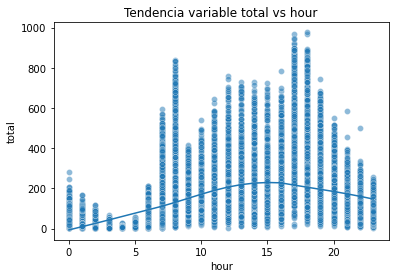

In [19]:
import statsmodels.api as sm
sns.scatterplot(data=bikes, x="hour", y="total", alpha=0.5)
lowess = sm.nonparametric.lowess 
smooth = lowess(bikes["total"],bikes["hour"])
plt.plot(smooth[:,0],smooth[:,1])
plt.title("Tendencia variable total vs hour")
plt.show()

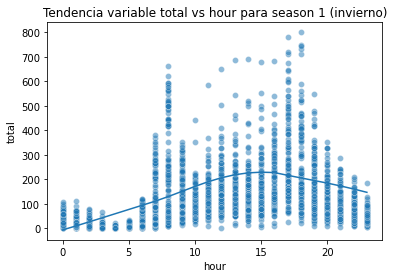

In [20]:
sns.scatterplot(data=bikes[bikes["season"]==1], x="hour", y="total", alpha=0.5)
lowess = sm.nonparametric.lowess 
smooth = lowess(bikes["total"],bikes["hour"])
plt.plot(smooth[:,0],smooth[:,1])
plt.title("Tendencia variable total vs hour para season 1 (invierno)")
plt.show()

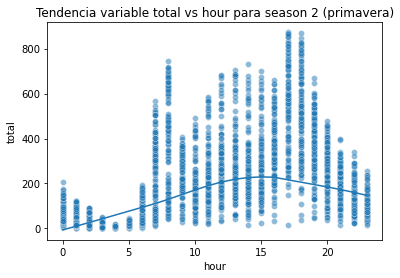

In [21]:
sns.scatterplot(data=bikes[bikes["season"]==2], x="hour", y="total", alpha=0.5)
lowess = sm.nonparametric.lowess 
smooth = lowess(bikes["total"],bikes["hour"])
plt.plot(smooth[:,0],smooth[:,1])
plt.title("Tendencia variable total vs hour para season 2 (primavera)")
plt.show()

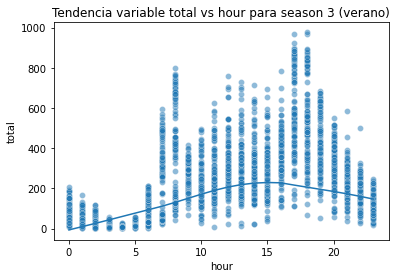

In [22]:
sns.scatterplot(data=bikes[bikes["season"]==3], x="hour", y="total", alpha=0.5)
lowess = sm.nonparametric.lowess 
smooth = lowess(bikes["total"],bikes["hour"])
plt.plot(smooth[:,0],smooth[:,1])
plt.title("Tendencia variable total vs hour para season 3 (verano)")
plt.show()

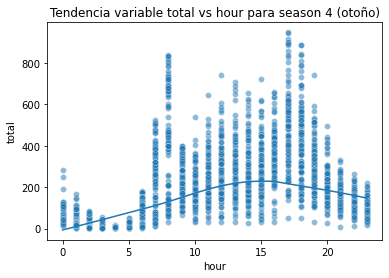

In [23]:
sns.scatterplot(data=bikes[bikes["season"]==4], x="hour", y="total", alpha=0.5)
lowess = sm.nonparametric.lowess 
smooth = lowess(bikes["total"],bikes["hour"])
plt.plot(smooth[:,0],smooth[:,1])
plt.title("Tendencia variable total vs hour para season 4 (otoño)")
plt.show()

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [24]:
# Celda 4

# Definición de la función mse_split para calular el error de una variable predictora j dado el punto de corte k
def mse_split(X_col, y, split):    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
       
    errors_l = y_l-np.mean(y_l)
    errors_r = y_r-np.mean(y_r)
    
    mse = np.average(np.square(np.concatenate([errors_l,errors_r])))
    
    return mse

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):    
    features = range(X.shape[1])
    
    # Calcular el mse del nodo actual y dejar dicho mse como punto de comparación, puede que sea mejor no particionar.
    mse_node = np.average(np.square(y-y.mean()))
    best_split = [None, None, mse_node]  # j, split, mse
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            mse = mse_split(X.iloc[:, j], y, split)
            if mse < best_split[2]:
                best_split = [j, split, mse]

    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_mse=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, mse=0)
        return tree
    
    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse)
    
    # Revisar el criterio de parada 
    if mse < min_mse:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    if split is None: # Puede que no se obtenga una nueva partición, ya que al particionar no mejora el mse, o este no se puede calcular porque no hay datos para particionar.
        return tree
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_mse=min_mse, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_mse=min_mse, max_depth=max_depth, num_pct=num_pct)

    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
            
    else:        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [25]:
# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 10
min_mse=0.001

tree = tree_grow(X_train, y_train, min_mse=min_mse, max_depth=max_depth, num_pct=num_pct)

In [26]:
y_test_pred = tree_predict(X_test, tree)

mse_dt_manual = mean_squared_error(y_test, y_test_pred)
mse_dt_manual

15516.383023390052

El error cuadrático medio del árbol de decisión manual en los datos de test es de 15516.383

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras \"season\" y \"hour\" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [27]:
# Celda 5
from sklearn.model_selection import GridSearchCV
params = {"max_depth":[None] + np.arange(1,10).tolist(), "min_samples_leaf":[1] + np.arange(1,10).tolist()}

dt_reg = DecisionTreeRegressor(random_state=42)

grid_reg = GridSearchCV(dt_reg, param_grid=params, cv=10, scoring='neg_mean_squared_error')
grid_reg.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [28]:
grid_reg.best_params_

{'max_depth': 9, 'min_samples_leaf': 1}

In [29]:
y_test_pred = grid_reg.predict(X_test)

mse_dt = mean_squared_error(y_test, y_test_pred)
mse_dt

13225.457029403828

El error cuadrático medio del árbol de decisión con scikit learn en los datos de test es de 13251.246

#### Comparación modelos punto 3 y punto 5

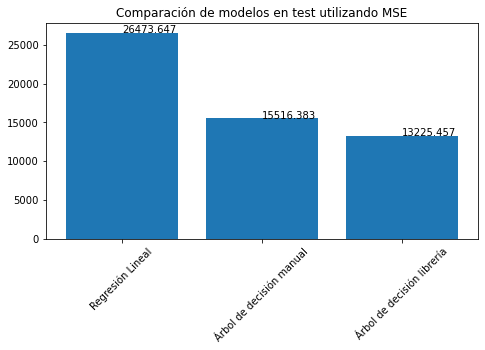

In [30]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos en test utilizando MSE")
ejeX = ['Regresión Lineal','Árbol de decisión manual','Árbol de decisión librería']
ejeY = [mse_lr,mse_dt_manual,mse_dt]
ejeY = [round(v,3) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation = 45)
plt.show()

Se puede observar que el MSE del árbol de decisión con librería es mucho menor que el de regresión lineal teniendo así mejor desempeño el árbol de decisión. Así mismo el construido con librería da mejor que el manual, muy seguramente por la optimización de parámetros.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [31]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [32]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [33]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [34]:
# Celda 6
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

#### Entrenamiento árbol de decisión

In [35]:
params = {"max_depth":[None] + np.arange(1,10).tolist(), "min_samples_leaf":[1] + np.arange(1,10).tolist()}

dt_clf = DecisionTreeClassifier(random_state=42)

grid_clf = GridSearchCV(dt_clf, param_grid=params, cv=10, scoring='accuracy')
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

In [36]:
grid_clf.best_params_

{'max_depth': 1, 'min_samples_leaf': 1}

In [37]:
y_test_pred = grid_clf.predict(X_test)

In [38]:
f1_dt = f1_score(y_test_pred, y_test)
acc_dt = accuracy_score(y_test_pred, y_test)

In [39]:
print('F1 Score:',f1_dt, '\nAccuracy:',acc_dt)

F1 Score: 0.6448598130841121 
Accuracy: 0.6453333333333333


#### Entrenamiento regresión logística

In [40]:
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [41]:
y_test_pred = lr_clf.predict(X_test)

In [42]:
f1_rl = f1_score(y_test_pred, y_test)
acc_rl = accuracy_score(y_test_pred, y_test)

In [43]:
print('F1 Score: ',f1_rl, '\nAccuracy: ',acc_rl)

F1 Score:  0.6098052384150436 
Accuracy:  0.6126666666666667


#### Comparación de modelos

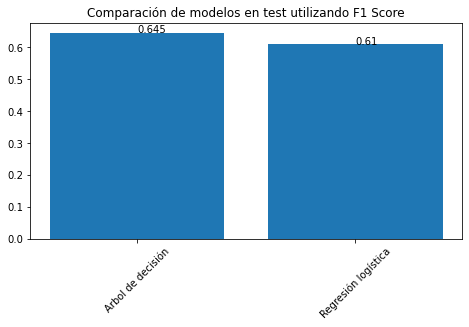

In [44]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos en test utilizando F1 Score")
ejeX = ['Arbol de decisión','Regresión logística']
ejeY = [f1_dt,f1_rl]
ejeY = [round(v,3) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation = 45)
plt.show()

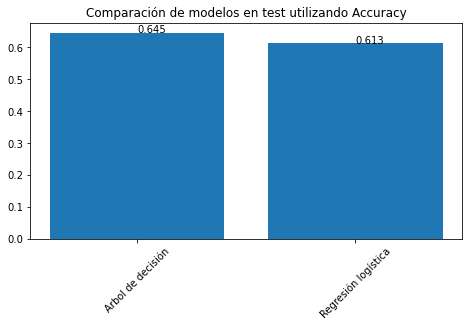

In [45]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos en test utilizando Accuracy")
ejeX = ['Arbol de decisión','Regresión logística']
ejeY = [acc_dt,acc_rl]
ejeY = [round(v,3) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation = 45)
plt.show()

El arbol de decisión presenta mejor desempeño que la regresión logística tanto para el F1 Score como para el Accuracy

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [46]:
from sklearn.ensemble import BaggingClassifier

#### 100 árboles de decisión donde max_depth tome un valor de su elección

In [47]:
# Celda 7
clf1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 5, random_state=42), n_estimators=100, max_samples=300, 
                         bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

clf1.fit(X_train, y_train)
y_pred_clf1 = clf1.predict(X_test)

f1_max_depth = f1_score(y_pred_clf1, y_test)
acc_max_depth = accuracy_score(y_pred_clf1, y_test)
print('F1 Score: ',f1_max_depth, '\nAccuracy: ',acc_max_depth)

F1 Score:  0.6517615176151762 
Accuracy:  0.6573333333333333


#### 100 árboles de decisión donde min_samples_leaf tome un valor de su elección

In [48]:
clf2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf = 1, random_state=42), n_estimators=100, max_samples=300,
                         bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)

clf2.fit(X_train, y_train)
y_pred_clf2 = clf2.predict(X_test)

f1_min_samples = f1_score(y_pred_clf2, y_test)
acc_min_samples = accuracy_score(y_pred_clf2, y_test)
print('F1 Score: ',f1_min_samples, '\nAccuracy: ',acc_min_samples)

F1 Score:  0.6567567567567568 
Accuracy:  0.6613333333333333


#### 100 regresiones logísticas

In [49]:
clf3 = BaggingClassifier(base_estimator=LogisticRegression(random_state=42), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf3.fit(X_train, y_train)
y_pred_clf3 = clf3.predict(X_test)

f1_lr= f1_score(y_pred_clf3, y_test)
acc_lr = accuracy_score(y_pred_clf3, y_test)
print('F1 Score: ',f1_lr, '\nAccuracy: ',acc_lr)

F1 Score:  0.6134055517941774 
Accuracy:  0.6193333333333333


#### Ensamble de los 3 modelos anteriores

Concatenamos el resultado de las predicciones de los 3 modelos anteriores y construimos un dataframe

In [50]:
df_y_pred = pd.concat([pd.Series(y_pred_clf1), pd.Series(y_pred_clf2), pd.Series(y_pred_clf3)],axis=1)
df_y_pred.columns=["clf1","clf2","clf3"]
df_y_pred

,clf1,clf2,clf3
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,0,0,0
...,...,...,...
1495,0,1,0
1496,0,0,0
1497,1,1,1
1498,0,0,0


Se asigna el valor de 1 donde haya predicción mayoritaria del valor de 1

In [51]:
y_pred_ensam = (df_y_pred.sum(axis=1) >= 2).astype(np.int)

In [52]:
f1_ensam = f1_score(y_pred_ensam, y_test)
acc_ensam = accuracy_score(y_pred_ensam, y_test)
print('F1 Score: ',f1_ensam, '\nAccuracy: ',acc_ensam)

F1 Score:  0.6430517711171662 
Accuracy:  0.6506666666666666


#### Comparación de resultados

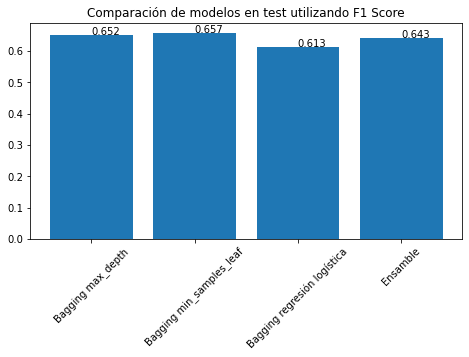

In [53]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos en test utilizando F1 Score")
ejeX = ['Bagging max_depth','Bagging min_samples_leaf','Bagging regresión logística', "Ensamble"]
ejeY = [f1_max_depth,f1_min_samples,f1_lr,f1_ensam]
ejeY = [round(v,3) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation = 45)
plt.show()

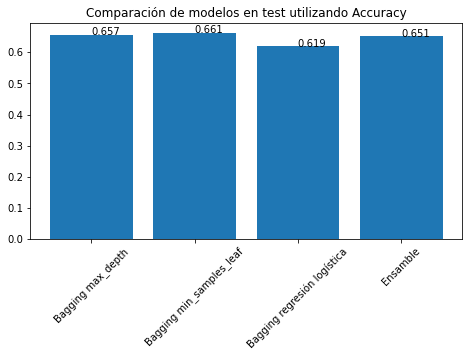

In [54]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos en test utilizando Accuracy")
ejeX = ['Bagging max_depth','Bagging min_samples_leaf','Bagging regresión logística', "Ensamble"]
ejeY = [acc_max_depth,acc_min_samples,acc_lr,acc_ensam]
ejeY = [round(v,3) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation = 45)
plt.show()

El bagging de los árboles de decisión utilizando el parámetro min_samples_leaf es el que obtiene mejores resultados tango de F1 Score como de Accuracy.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

A continuación, se utilizará el resultado del entrenamiento de cada clasificador del punto 7 para realizar la votación ponderada

In [55]:
def votacion_ponderada(clf):
    errors = np.zeros(clf.n_estimators)
    y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

    for i in range(clf.n_estimators):
        oob_sample = ~clf.estimators_samples_[i]
        y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
        errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)

    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
    
    return y_pred

#### 100 árboles de decisión donde max_depth tome un valor de su elección

In [56]:
# Celda 8
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
y_pred = votacion_ponderada(clf1)

f1_max_depth_vp = f1_score(y_pred, y_test)
acc_max_depth_vp = accuracy_score(y_pred, y_test)
print('F1 Score: ',f1_max_depth_vp, '\nAccuracy: ',acc_max_depth_vp)

F1 Score:  0.6385041551246536 
Accuracy:  0.652


#### 100 árboles de decisión donde min_samples_leaf tome un valor de su elección

In [57]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
y_pred = votacion_ponderada(clf2)

f1_min_samples_vp = f1_score(y_pred, y_test)
acc_min_samples_vp = accuracy_score(y_pred, y_test)
print('F1 Score: ',f1_min_samples_vp, '\nAccuracy: ',acc_min_samples_vp)

F1 Score:  0.6631087391594397 
Accuracy:  0.6633333333333333


#### 100 regresiones logísticas

In [58]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
y_pred = votacion_ponderada(clf3)

f1_lr_vp= f1_score(y_pred, y_test)
acc_lr_vp = accuracy_score(y_pred, y_test)
print('F1 Score: ',f1_lr_vp, '\nAccuracy: ',acc_lr_vp)

F1 Score:  0.6171505739365294 
Accuracy:  0.622


#### Comparación de resultados

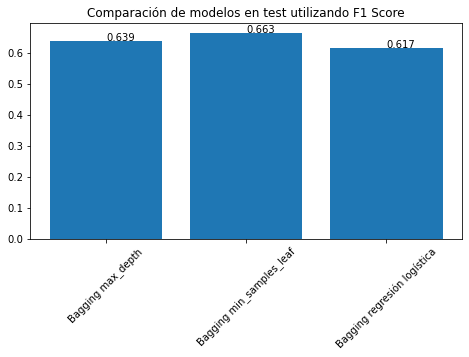

In [59]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos en test utilizando F1 Score")
ejeX = ['Bagging max_depth','Bagging min_samples_leaf','Bagging regresión logística']
ejeY = [f1_max_depth_vp,f1_min_samples_vp,f1_lr_vp]
ejeY = [round(v,3) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation = 45)
plt.show()

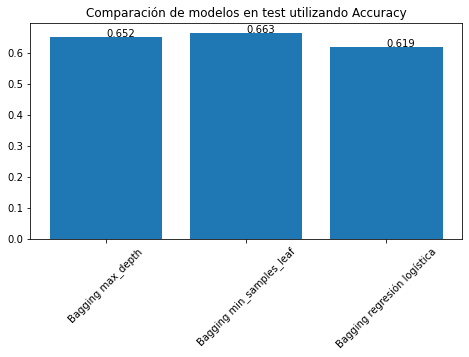

In [60]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos en test utilizando Accuracy")
ejeX = ['Bagging max_depth','Bagging min_samples_leaf','Bagging regresión logística']
ejeY = [acc_max_depth_vp,acc_min_samples_vp,acc_lr]
ejeY = [round(v,3) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation = 45)
plt.show()

El bagging de los árboles de decisión utilizando el parámetro min_samples_leaf es el que obtiene mejores resultados tango de F1 Score como de Accuracy.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Tanto para el punto 7 como el punto 8 se obtuvieron mejores resultados con el escenario de los 100 árboles con el parámetro min_samples_leaf para ambas métricas F1 Score y  Accuracy, aunque en todos los escenarios se obtuvieron métricas muy similares.

La mejor métrica final fue del bagging de los 100 árboles con el parámetro min_samples_leaf utilizando votación ponderada. 

**Ventajas:**
* Los modelos de bagging permiten reducir la varianza e incrementar la precisión.
* La votación ponderada tiene en cuenta los errores de cada clasificador para dar peso a la votación, lo cual puede dar aun mayor precisión.

**Desventajas:**
* Baggin requiere mayor poder computacional, aunque la votación ponderada requiere aun más a la hora de calcular los pesos.
* Pérdida de interpretabilidad.